![image.png](https://i.imgur.com/a3uAqnb.png)

# **🐱🐶 Cats & Dogs Classification with Pretrained Model (EfficientNet)**
In this lab, we will:

✅ Build a **custom Dataset class** for the **Cats & Dogs dataset**  
✅ Use a **pretrained EfficientNet-B0 model** for classification  
✅ Train and evaluate the model  


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import kagglehub
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
# Please uncomment this out when you are running this lab on google colab!
import os

# Set KaggleHub cache to a directory inside /content/
os.environ["KAGGLEHUB_CACHE"] = "/content/data"

In [3]:
# Download the dataset
path = kagglehub.dataset_download("marquis03/cats-and-dogs")
path

Using Colab cache for faster access to the 'cats-and-dogs' dataset.


'/kaggle/input/cats-and-dogs'

## 1️⃣ Dataset Class

In [4]:
class CatsDogsDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.split = split


        csv_file = os.path.join(root_dir, f'{split}.csv')
        self.data = pd.read_csv(csv_file)

        # Extract image paths and labels from the csv files provided in the dataset
        self.image_paths = self.data['image:FILE'].values
        self.labels = self.data['category'].values

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Construct full image path
        img_path = os.path.join(self.root_dir, self.image_paths[idx])

        # Read image
        image = Image.open(img_path).convert('RGB')
        label = float(self.labels[idx])                     # Always store your labels in float

        # Apply transforms if any
        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
# 1. Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create dataset objects
train_dataset = CatsDogsDataset(path, split='train', transform=transform)
valid_dataset = CatsDogsDataset(path, split='val', transform=test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=2)

# Check a batch of images
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}, Labels: {labels.shape}")

Batch shape: torch.Size([32, 3, 224, 224]), Labels: torch.Size([32])


In [9]:
train_dataset.__len__(), valid_dataset.__len__()

(275, 70)

#### In the transformation pipeline, we use **specific mean and standard deviation values**

## **🔹 Where Do These Values Come From?**
✅ These values were found using the **ImageNet dataset**, a large-scale dataset used for training **pretrained models** like ResNet, EfficientNet, and VGG.  
✅ **Reference**: [ImageNet Dataset](https://paperswithcode.com/dataset/imagenet)  

## **🔹 Why Do We Use Them?**
1️⃣ **Pretrained Models Expect These Values**  
   - If a model was trained using a certain mean & std, we should use the **same values** for inference/training.
   - This ensures the input distribution matches what the model was trained on.
   - We are fintuning an EfficientNet here, which was pretrained on Imagenet, so will use these values.

### Let's display some images

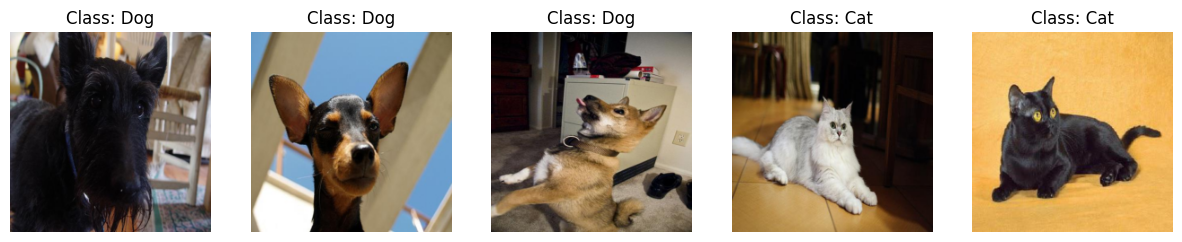

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Display 5 images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

imgs_indices = [270,233,110,89,15]

for i in range(5):
    img, label = train_dataset[imgs_indices[i]]  # Load image & label

    # Convert tensor to numpy for visualization
    img_np = img.numpy().transpose(1, 2, 0)  # (C, H, W) → (H, W, C)

    # Show image
    axes[i].imshow(img_np)
    axes[i].set_title(f'Class: {"Cat" if label == 0 else "Dog"}')
    axes[i].axis('off')

plt.show()

## 2️⃣ Model Class

## CNN Model

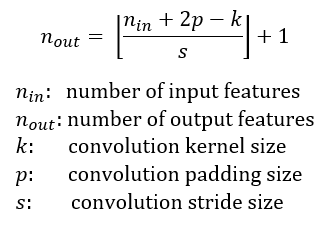

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128*28*28, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Instantiate model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

num_classes = 2
model = SimpleCNN(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 30

In [ ]:
train_losses = []
train_accuracies = []

In [ ]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device).long()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / total
    train_acc = 100 * correct / total

    train_losses.append(train_loss)
    train_accuracies.append(train_acc )
    print(f"Epoch {epoch+1}, Loss: {running_loss:.3f}, Training Acc: {train_acc:.2f}%")

In [ ]:
# Validate
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in tqdm(valid_loader):
        images, labels = images.to(device), labels.to(device).long()
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
val_acc = 100 * correct / total
print(f'Validation Accuracy: {val_acc:.2f}%')

100%|██████████| 3/3 [00:00<00:00,  6.24it/s]

Validation Accuracy: 60.00%


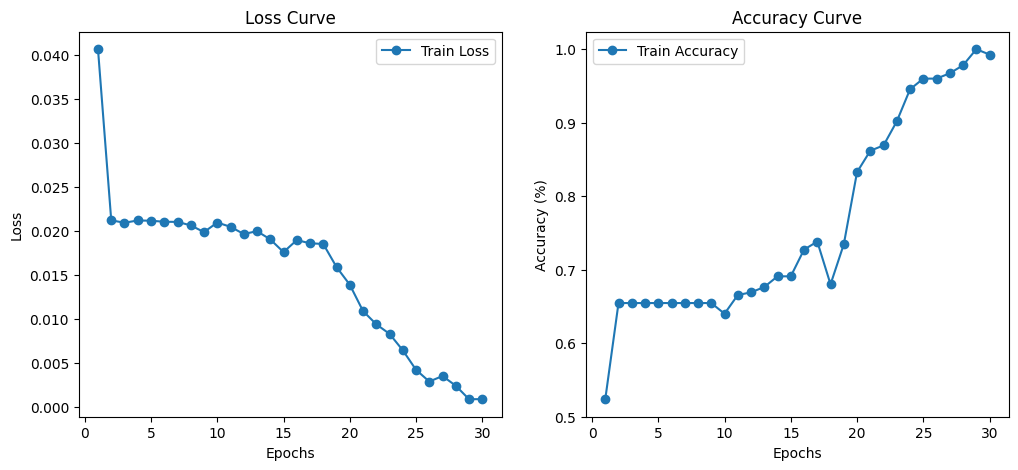

In [ ]:
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label="Train Loss", marker='o')
# plt.plot(range(1, epochs+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label="Train Accuracy", marker='o')
# plt.plot(range(1, epochs+1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.show()

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()

        # Convolutional layers + BatchNorm
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers + BatchNorm
        self.fc1 = nn.Linear(128*28*28, 256)
        self.bn_fc1 = nn.BatchNorm1d(256)

        self.fc2 = nn.Linear(256, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)

        x = self.relu(self.bn_fc1(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
model = SimpleCNN(num_classes).to(device)
train_losses = []
train_accuracies = []

In [ ]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device).long()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / total
    train_acc = 100 * correct / total

    train_losses.append(train_loss)
    train_accuracies.append(train_acc )
    print(f"Epoch {epoch+1}, Loss: {running_loss:.3f}, Training Acc: {train_acc:.2f}%")

100%|██████████| 9/9 [00:01<00:00,  6.91it/s]


Epoch 1, Loss: 6.659, Training Acc: 46.91%


100%|██████████| 9/9 [00:01<00:00,  7.12it/s]


Epoch 2, Loss: 6.768, Training Acc: 44.00%


100%|██████████| 9/9 [00:01<00:00,  5.77it/s]


Epoch 3, Loss: 6.742, Training Acc: 41.45%


100%|██████████| 9/9 [00:01<00:00,  5.20it/s]


Epoch 4, Loss: 6.686, Training Acc: 48.00%


100%|██████████| 9/9 [00:01<00:00,  7.15it/s]


Epoch 5, Loss: 6.844, Training Acc: 40.73%


100%|██████████| 9/9 [00:01<00:00,  7.18it/s]


Epoch 6, Loss: 6.943, Training Acc: 42.18%


100%|██████████| 9/9 [00:01<00:00,  7.08it/s]


Epoch 7, Loss: 6.678, Training Acc: 44.73%


100%|██████████| 9/9 [00:01<00:00,  7.00it/s]


Epoch 8, Loss: 6.758, Training Acc: 46.91%


100%|██████████| 9/9 [00:01<00:00,  7.11it/s]


Epoch 9, Loss: 6.975, Training Acc: 41.09%


100%|██████████| 9/9 [00:01<00:00,  7.12it/s]


Epoch 10, Loss: 6.758, Training Acc: 42.18%


100%|██████████| 9/9 [00:01<00:00,  7.33it/s]


Epoch 11, Loss: 6.661, Training Acc: 48.73%


100%|██████████| 9/9 [00:01<00:00,  6.16it/s]


Epoch 12, Loss: 6.717, Training Acc: 45.45%


100%|██████████| 9/9 [00:02<00:00,  4.40it/s]


Epoch 13, Loss: 6.764, Training Acc: 46.91%


100%|██████████| 9/9 [00:01<00:00,  6.30it/s]


Epoch 14, Loss: 6.686, Training Acc: 47.27%


100%|██████████| 9/9 [00:01<00:00,  7.09it/s]


Epoch 15, Loss: 6.811, Training Acc: 46.91%


100%|██████████| 9/9 [00:01<00:00,  7.34it/s]


Epoch 16, Loss: 6.725, Training Acc: 45.09%


100%|██████████| 9/9 [00:01<00:00,  7.06it/s]


Epoch 17, Loss: 6.729, Training Acc: 45.45%


100%|██████████| 9/9 [00:01<00:00,  6.98it/s]


Epoch 18, Loss: 6.717, Training Acc: 48.36%


100%|██████████| 9/9 [00:01<00:00,  6.07it/s]


Epoch 19, Loss: 6.651, Training Acc: 47.64%


100%|██████████| 9/9 [00:01<00:00,  7.16it/s]


Epoch 20, Loss: 6.868, Training Acc: 44.73%


100%|██████████| 9/9 [00:01<00:00,  5.62it/s]


Epoch 21, Loss: 6.732, Training Acc: 45.09%


100%|██████████| 9/9 [00:01<00:00,  5.21it/s]


Epoch 22, Loss: 6.701, Training Acc: 44.73%


100%|██████████| 9/9 [00:01<00:00,  7.15it/s]


Epoch 23, Loss: 6.733, Training Acc: 44.36%


100%|██████████| 9/9 [00:01<00:00,  7.37it/s]


Epoch 24, Loss: 6.811, Training Acc: 45.09%


100%|██████████| 9/9 [00:01<00:00,  7.14it/s]


Epoch 25, Loss: 6.821, Training Acc: 43.64%


100%|██████████| 9/9 [00:01<00:00,  6.09it/s]


Epoch 26, Loss: 6.711, Training Acc: 46.91%


100%|██████████| 9/9 [00:01<00:00,  7.25it/s]


Epoch 27, Loss: 6.860, Training Acc: 41.45%


100%|██████████| 9/9 [00:01<00:00,  7.24it/s]


Epoch 28, Loss: 6.828, Training Acc: 41.45%


100%|██████████| 9/9 [00:01<00:00,  7.31it/s]


Epoch 29, Loss: 6.640, Training Acc: 47.64%


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]

Epoch 30, Loss: 6.921, Training Acc: 43.27%


In [ ]:
# Validate
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in tqdm(valid_loader):
        images, labels = images.to(device), labels.to(device).long()
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
val_acc = 100 * correct / total
print(f'Validation Accuracy: {val_acc:.2f}%')

100%|██████████| 3/3 [00:00<00:00,  8.49it/s]

Validation Accuracy: 45.71%


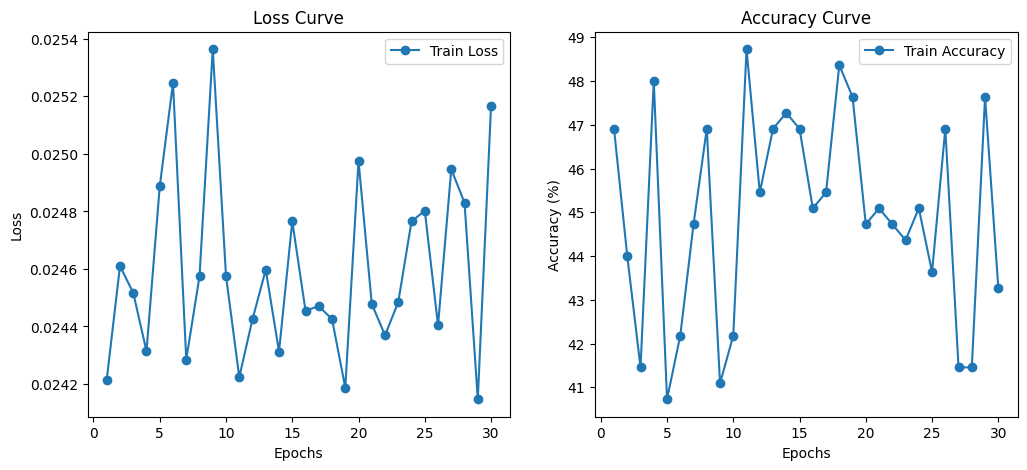

In [ ]:
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label="Train Loss", marker='o')
# plt.plot(range(1, epochs+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label="Train Accuracy", marker='o')
# plt.plot(range(1, epochs+1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.show()

## Pretrained Model

#### Instead of training from scratch, we use **EfficientNet-B0** with a modified output layer.


In [10]:
from torchvision import models

# Load pretrained EfficientNet-B0
model = models.efficientnet_b0(pretrained=True)

# Freeze the feature extractor
for param in model.features.parameters():
    param.requires_grad = False

# Modify the classifier for binary classification (cats vs. dogs)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)  # 2 classes

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 110MB/s] 


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## 3️⃣ Training and Validation Loops

In [11]:
from tqdm import tqdm    # Shows progress bar

# 🔹 Training Loop
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images).squeeze()  # The model outputs in shape [batch_size,1]. We convert them to [batch_size,] so the loss accepts them.
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Track accuracy
        predictions = torch.sigmoid(outputs) > 0.5  # Get predicted class
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# 🔹 Validation Loop
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images).squeeze()  # The model outputs in shape [batch_size,1]. We convert them to [batch_size,] so the loss accepts them.
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Compute accuracy
            predictions = torch.sigmoid(outputs) > 0.5  # Get predicted class
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


## 4️⃣ Running Training

In [12]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Classification loss (Use when there is no softmax/sigmoid in the last layer)
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam optimizer
num_epochs = 10 # Number of epochs


# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training process
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, valid_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Train Accuracy={train_accuracy:.2f}%, "
          f"Val Loss={val_loss:.4f}, Val Accuracy={val_accuracy:.2f}%")


100%|██████████| 9/9 [00:02<00:00,  3.49it/s]


Epoch 1/10: Train Loss=0.7325, Train Accuracy=41.09%, Val Loss=0.7370, Val Accuracy=44.29%


100%|██████████| 9/9 [00:01<00:00,  7.52it/s]


Epoch 2/10: Train Loss=0.7182, Train Accuracy=46.18%, Val Loss=0.7091, Val Accuracy=47.14%


100%|██████████| 9/9 [00:01<00:00,  7.75it/s]


Epoch 3/10: Train Loss=0.6885, Train Accuracy=56.36%, Val Loss=0.6899, Val Accuracy=61.43%


100%|██████████| 9/9 [00:01<00:00,  7.54it/s]


Epoch 4/10: Train Loss=0.6617, Train Accuracy=63.27%, Val Loss=0.6715, Val Accuracy=64.29%


100%|██████████| 9/9 [00:01<00:00,  5.58it/s]


Epoch 5/10: Train Loss=0.6571, Train Accuracy=65.09%, Val Loss=0.6522, Val Accuracy=68.57%


100%|██████████| 9/9 [00:01<00:00,  6.41it/s]


Epoch 6/10: Train Loss=0.6342, Train Accuracy=75.64%, Val Loss=0.6351, Val Accuracy=74.29%


100%|██████████| 9/9 [00:01<00:00,  7.48it/s]


Epoch 7/10: Train Loss=0.6282, Train Accuracy=72.36%, Val Loss=0.6202, Val Accuracy=72.86%


100%|██████████| 9/9 [00:01<00:00,  7.56it/s]


Epoch 8/10: Train Loss=0.6202, Train Accuracy=75.27%, Val Loss=0.6050, Val Accuracy=75.71%


100%|██████████| 9/9 [00:01<00:00,  7.19it/s]


Epoch 9/10: Train Loss=0.5997, Train Accuracy=81.82%, Val Loss=0.5956, Val Accuracy=78.57%


100%|██████████| 9/9 [00:01<00:00,  7.63it/s]


Epoch 10/10: Train Loss=0.5909, Train Accuracy=78.55%, Val Loss=0.5852, Val Accuracy=78.57%


### Plot loss and some predictions

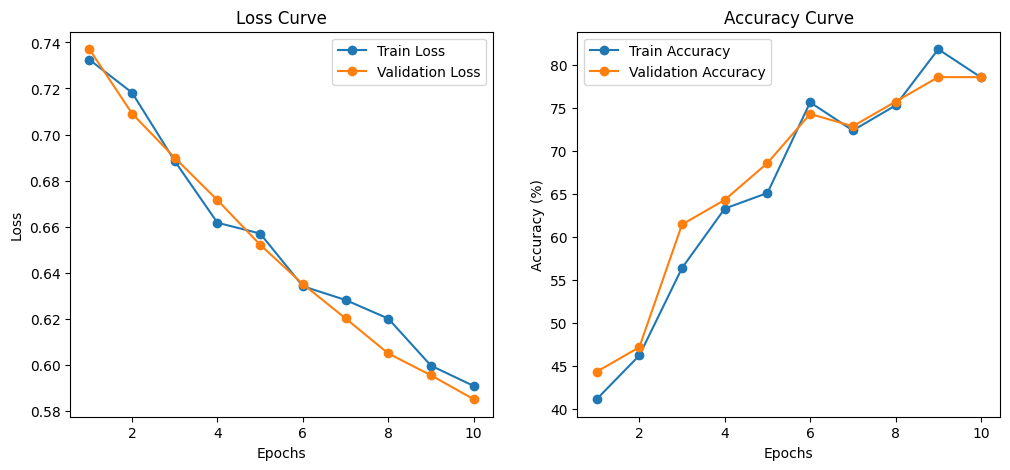

In [13]:
import matplotlib.pyplot as plt

# Plot loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.show()


# Very nice
Now you can detect all cats and dogs

![No cat is safe](https://i.imgur.com/1r243HR.gif)

### Contributed by: Ali Habibullah & Mohamed Eltayeb
